<div style="line-height:0.5">
<h1 style="color:#BF66F2 ">  Autoencoders in PyTorch 2 </h1>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> SmoothL1Loss + Adam + Adagrad + Adadelta + RMSprop
</span>
</div>

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np

from PIL import Image

In [2]:
# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 Dataset and DataLoader
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 94490126.35it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


<h2 style="color:#BF66F2 "> <u> Example #1 </u></h2>

In [6]:
class SimpleAutoencoder(nn.Module):
    """ Autoencoder for compressing and reconstructing CIFAR-10 images.

    Encoder:
        - Conv2d: 3 -> 16, kernel 3, stride 2, padding 1
        - ReLU
        - MaxPool2d: kernel 2, stride 2

    Decoder:
        - ConvTranspose2d: 16 -> 8, kernel 2, stride 2
        - ReLU
        - ConvTranspose2d: 8 -> 3, kernel 2, stride 2
        - Sigmoid
    """
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
### Initialize Model, Loss Function, and Optimizer
model = SimpleAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train Loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

In [9]:
# Test on a Batch
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [10]:
data_iter = iter(test_loader)
img_tensor, _ = next(data_iter)

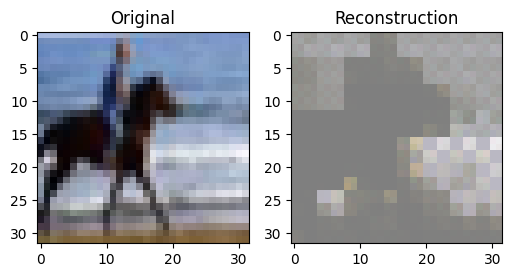

In [11]:
with torch.no_grad():
    reconstruction = model(img_tensor)

# Display image
original_image = np.clip(img_tensor[0].numpy().transpose(1, 2, 0) / 2 + 0.5, 0, 1)
reconstruction_image = np.clip(reconstruction[0].numpy().transpose(1, 2, 0) / 2 + 0.5, 0, 1)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(reconstruction_image)
plt.title("Reconstruction")
plt.show()


<h2 style="color:#BF66F2 "> <u> Example #2 </u></h2>

In [13]:
def process_image(image_path):
    """ Pre-process the test image in the same way as training. """
    img = Image.open(image_path).convert('RGB')

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Apply transformations and add batch dimension
    img_tensor = transform(img).unsqueeze(0)

    return img_tensor, img

def visualize_reconstruction(model, img_tensor, original_image):
    """ Reconstruct and visualize the image. """
    
    # Set evaluation mode
    model.eval()
    # Set No gradient computation needed during inference
    with torch.no_grad():
        reconstruction = model(img_tensor)

    # Convert tensors to images and display
    original_img = original_image
    reconstructed_img = transforms.ToPILImage()(reconstruction.squeeze())

    # Display
    plt.figure(figsize=(9, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.title('Reconstructed Image')
    plt.show()

In [15]:
from google.colab import files

In [16]:
uploaded = files.upload()

Saving cat_try_this.jpeg to cat_try_this.jpeg


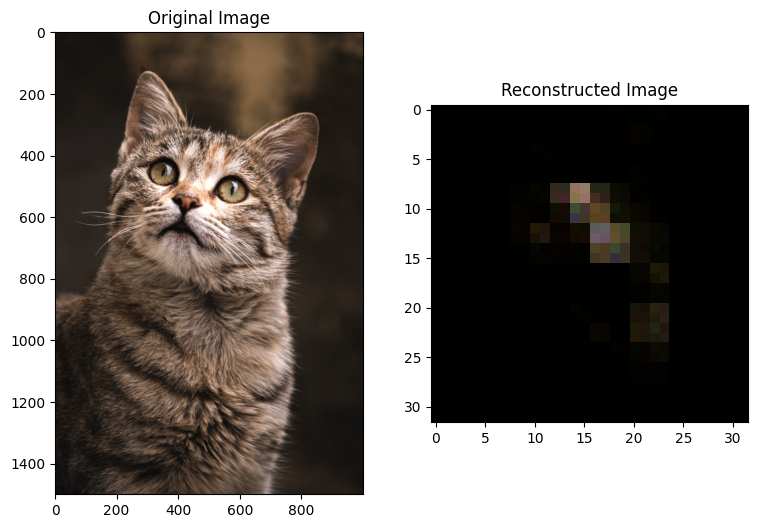

In [17]:
img_tensor, original_image = process_image('/content/cat_try_this.jpeg')
visualize_reconstruction(model, img_tensor, original_image)


<h2 style="color:#BF66F2 "> <u> Example #3 </u></h2>

In [18]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [44]:
# Initialize Model, Loss Function, and Optimizer
model_improved = ImprovedAutoencoder()
#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
#ptimizer = optim.Adagrad(model.parameters(), lr=0.001)
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9)

In [45]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model_improved(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

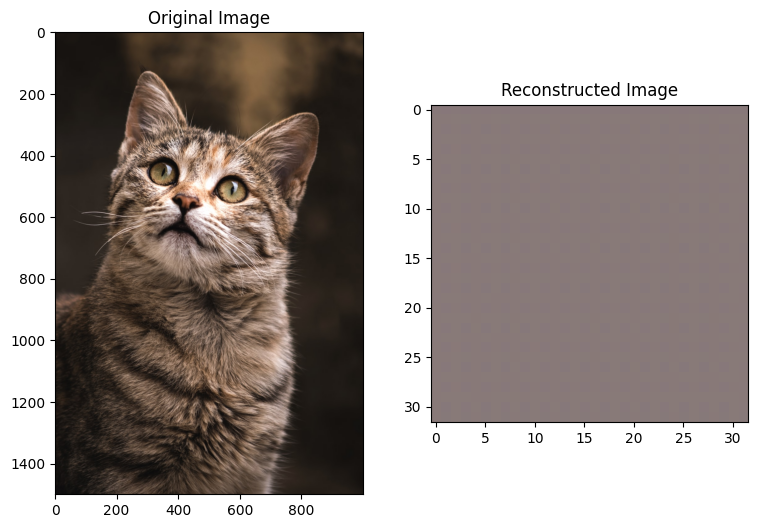

In [46]:
img_tensor, original_image = process_image('/content/cat_try_this.jpeg')
visualize_reconstruction(model_improved, img_tensor, original_image)


<h2 style="color:#BF66F2 "> <u> Example #4 </u></h2>

In [64]:
import torch
import torch.nn as nn

class ImprovedAutoencoder2(nn.Module):
    """ An autoencoder model for image compression and reconstruction.

    - Encoder Layers:
        - Conv2d:         [3, 32], kernel_size=4, stride=2, padding=1
        - ReLU
        - Conv2d:        [32, 64], kernel_size=4, stride=2, padding=1
        - ReLU
        - Conv2d:        [64, 128], kernel_size=4, stride=2, padding=1
        - ReLU
        - Conv2d:        [128, 256], kernel_size=4, stride=2, padding=1
        - ReLU

    - Decoder Layers:
        - ConvTranspose2d: [256, 128], kernel_size=4, stride=2, padding=1
        - ReLU
        - ConvTranspose2d: [128, 64], kernel_size=4, stride=2, padding=1
        - ReLU
        - ConvTranspose2d: [64, 32], kernel_size=4, stride=2, padding=1
        - ReLU
        - ConvTranspose2d: [32, 3], kernel_size=4, stride=2, padding=1
        - Sigmoid
    """
    def __init__(self):
        super(ImprovedAutoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [65]:
# Initialize Model, Loss Function, and Optimizer
model_improved2 = ImprovedAutoencoder2()
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(model_improved2.parameters(), lr=0.00001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
#ptimizer = optim.Adagrad(model.parameters(), lr=0.001)
#optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9)

In [66]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model_improved2(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

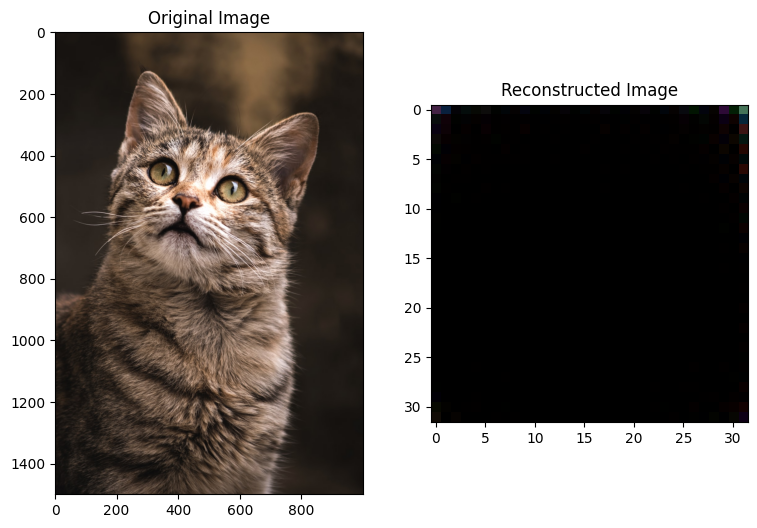

In [67]:
img_tensor, original_image = process_image('/content/cat_try_this.jpeg')
visualize_reconstruction(model_improved2, img_tensor, original_image)

<h2 style="color:#BF66F2 "> <u> Example #4 </u></h2>

In [56]:
class EnhancedAutoencoder(nn.Module):
    """ An autoencoder model for image reconstruction.

    - Encoder:
        - Conv2d: 3 input channels, 64 output channels, kernel size 3, stride 1, padding 1
        - ReLU
        - MaxPool2d: kernel size 2, stride 2
        - Conv2d: 64 input channels, 128 output channels, kernel size 3, stride 1, padding 1
        - BatchNorm2d: 128 features
        - ReLU
        - MaxPool2d: kernel size 2, stride 2

    - Decoder:
        - ConvTranspose2d: 128 input channels, 64 output channels, kernel size 2, stride 2
        - BatchNorm2d: 64 features
        - ReLU
        - ConvTranspose2d: 64 input channels, 3 output channels, kernel size 2, stride 2
        - Sigmoid
    """
    def __init__(self):
        super(EnhancedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [57]:
# Initialize Model, Loss Function, and Optimizer
model_improved3 = EnhancedAutoencoder()
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(model_improved3.parameters(), lr=0.00001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
#ptimizer = optim.Adagrad(model.parameters(), lr=0.001)
#optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9)

In [58]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model_improved3(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

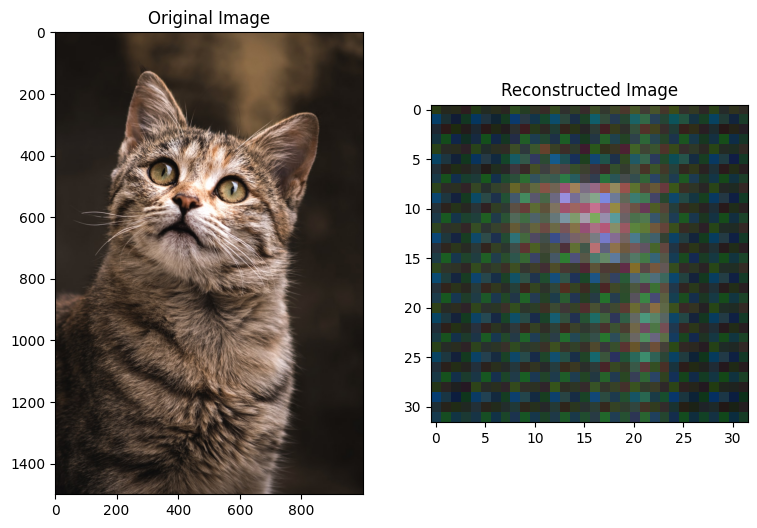

In [59]:
img_tensor, original_image = process_image('/content/cat_try_this.jpeg')
visualize_reconstruction(model_improved3, img_tensor, original_image)